In [1]:
import sklearn
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from helper_functions import plot_decision_boundary, accuracy_fn

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

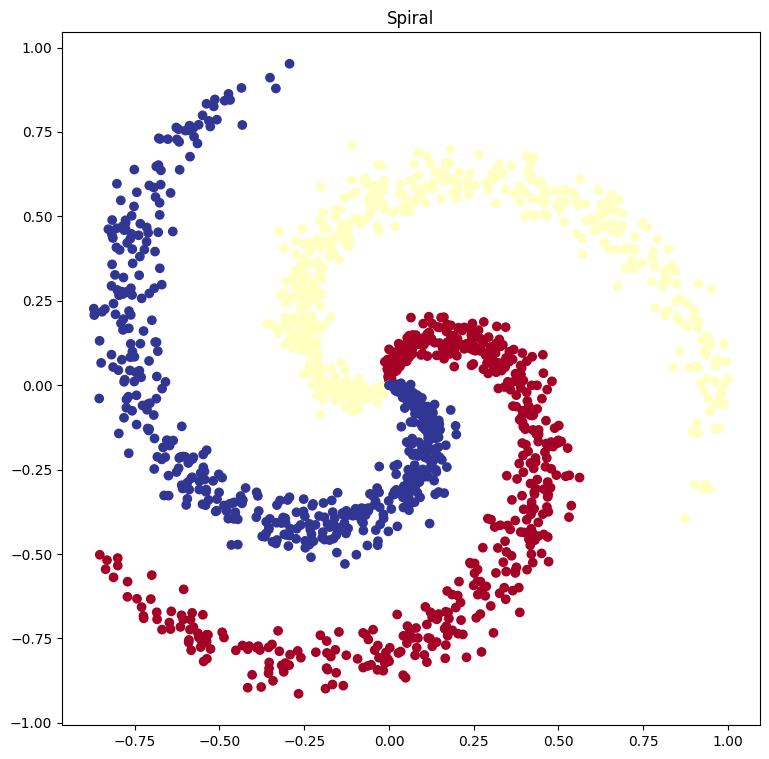

In [3]:
N = 500
D = 2
K = 3

X_spiral = np.zeros((N * K, D))
y_spiral = np.zeros(N * K, dtype="uint8")

for i in range(K):
  ix = range(N * i, N * (i + 1))
  r = np.linspace(0.0, 1, N)
  t = np.linspace(i * 4, (i + 1) * 4, N) + np.random.randn(N) * 0.2

  X_spiral[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
  y_spiral[ix] = i


plt.figure(figsize=(9, 9))
plt.title("Spiral")
plt.scatter(X_spiral[:, 0],
            X_spiral[:, 1],
            c=y_spiral,
            cmap=plt.cm.RdYlBu);

In [4]:
print(type(X_spiral), type(y_spiral))
print(X_spiral.shape, y_spiral.shape)
print(X_spiral.dtype, y_spiral.dtype)


<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(1500, 2) (1500,)
float64 uint8


In [5]:
X_spiral = torch.from_numpy(X_spiral).type(torch.float32)
y_spiral = torch.from_numpy(y_spiral).type(torch.LongTensor)

In [6]:
print(type(X_spiral), type(y_spiral))
print(X_spiral.shape, y_spiral.shape)
print(X_spiral.dtype, y_spiral.dtype)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([1500, 2]) torch.Size([1500])
torch.float32 torch.int64


## splitting data two ways into train and test 

In [7]:
X_spiral_train, X_spiral_test, y_spiral_train, y_spiral_test = train_test_split(X_spiral, y_spiral,
                                                                                test_size=0.2,
                                                                                random_state=50)

In [8]:
X_spiral_train.shape, X_spiral_test.shape, y_spiral_train.shape, y_spiral_test.shape

(torch.Size([1200, 2]),
 torch.Size([300, 2]),
 torch.Size([1200]),
 torch.Size([300]))

In [9]:
class SpiralModelV1(nn.Module):
    def __init__(self, input_features, output_features):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=output_features)
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

model_1 = SpiralModelV1(2, 3).to(device)

In [10]:
def get_model_architecture(model):
    model_architecture = str(model).replace("(", "").replace(")", "")
    return model_architecture
model_1_architecture = get_model_architecture(model_1)

In [11]:
loss_fn_1 = nn.CrossEntropyLoss()
optimizer_1 = torch.optim.SGD(params=model_1.parameters(),
                              lr=0.1)
sgd001_1 = torch.optim.SGD(params=model_1.parameters(),
                           lr=0.01)
adam001_1 = torch.optim.Adam(params=model_1.parameters(),
                            lr=0.01)
adam01_1 = torch.optim.Adam(params=model_1.parameters(),
                            lr=0.1)

In [12]:
def get_optimizer_info(optimizer):
    optimizer_name = optimizer.__class__.__name__
    optimizer_lr = optimizer.param_groups[0]["lr"]
    return optimizer_name, optimizer_lr
optimizer_1_name, optimizer_1_lr = get_optimizer_info(optimizer_1)

In [13]:

def train_step(model, loss_fn, accuracy_fn, optimizer, X_train, y_train):
    model.train()
    y_logits = model(X_train)
    y_pred = torch.softmax(y_logits, dim=1)
    y_pred = torch.argmax(y_pred, dim=1)
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item(), acc

In [14]:
def test_step(model, loss_fn, accuracy_fn, X_test, y_test):
    model.eval()
    with torch.inference_mode():
        test_logits = model(X_test)
        test_pred = torch.softmax(test_logits, dim=1)
        test_pred = torch.argmax(test_pred, dim=1)
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)
    return test_loss.item(), test_acc

In [15]:
def train_loop(model, loss_fn, accuracy_fn, optimizer, X_train, y_train, X_test, y_test, num_epochs, print_freq, device=None):
    torch.manual_seed(50)
    torch.cuda.manual_seed(50)

    X_train, y_train = X_train.to(device), y_train.to(device)
    X_test, y_test = X_test.to(device), y_test.to(device)

    epochs_count = []
    loss_values = []
    test_loss_values = []
    acc_values = []
    test_acc_values = []

    for epoch in range(num_epochs):
        loss, acc = train_step(model, loss_fn, accuracy_fn, optimizer, X_train, y_train)
        test_loss, test_acc = test_step(model, loss_fn, accuracy_fn, X_test, y_test)

        if epoch % print_freq == 0:
            epochs_count.append(epoch)
            loss_values.append(loss)
            acc_values.append(acc)
            test_loss_values.append(test_loss)
            test_acc_values.append(test_acc)
            print(f"Epoch: {epoch} | Loss: {loss:.3f} | Acc: {acc:.3f} | Test Loss: {test_loss:.3f} | Test Acc: {test_acc:.3f}")
    return epochs_count, loss_values, test_loss_values, acc_values,  test_acc_values

In [16]:
epochs_count_1, loss_values_1, test_loss_values_1, acc_values_1, test_acc_values_1 = train_loop(model_1, loss_fn_1, 
                                                                                                accuracy_fn, optimizer_1,
                                                                                                X_spiral_train, 
                                                                                                y_spiral_train, 
                                                                                                X_spiral_test,
                                                                                                y_spiral_test,
                                                                                                num_epochs=2050, print_freq=50,  
                                                                                                device=None)

Epoch: 0 | Loss: 1.064 | Acc: 51.333 | Test Loss: 1.038 | Test Acc: 50.000
Epoch: 50 | Loss: 0.752 | Acc: 53.500 | Test Loss: 0.749 | Test Acc: 54.000
Epoch: 100 | Loss: 0.709 | Acc: 55.000 | Test Loss: 0.707 | Test Acc: 54.667
Epoch: 150 | Loss: 0.682 | Acc: 56.583 | Test Loss: 0.681 | Test Acc: 56.333
Epoch: 200 | Loss: 0.656 | Acc: 58.167 | Test Loss: 0.657 | Test Acc: 59.333
Epoch: 250 | Loss: 0.628 | Acc: 61.750 | Test Loss: 0.633 | Test Acc: 62.333
Epoch: 300 | Loss: 0.599 | Acc: 63.667 | Test Loss: 0.608 | Test Acc: 64.333
Epoch: 350 | Loss: 0.571 | Acc: 66.750 | Test Loss: 0.583 | Test Acc: 66.000
Epoch: 400 | Loss: 0.544 | Acc: 70.000 | Test Loss: 0.559 | Test Acc: 69.000
Epoch: 450 | Loss: 0.517 | Acc: 72.833 | Test Loss: 0.536 | Test Acc: 70.000
Epoch: 500 | Loss: 0.492 | Acc: 75.083 | Test Loss: 0.514 | Test Acc: 70.333
Epoch: 550 | Loss: 0.469 | Acc: 76.333 | Test Loss: 0.493 | Test Acc: 72.333
Epoch: 600 | Loss: 0.447 | Acc: 78.000 | Test Loss: 0.473 | Test Acc: 73.667
Ep

In [17]:
def plot_graphs(epochs__count, loss__values, test__loss_values, acc__values, test__acc_values):
    fig = plt.figure(figsize=(16, 7))
    plt.subplot(1, 2, 1)
    plt.grid(True)
    plt.title("Train vs Test Loss")
    plt.plot(epochs__count, np.array(torch.tensor(loss__values).numpy()), label="Train Loss")
    plt.plot(epochs__count, np.array(torch.tensor(test__loss_values).numpy()), label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend();
    plt.subplot(1, 2, 2)
    plt.grid(True)
    plt.title("Train vs Test Accuracy")
    plt.plot(epochs__count, np.array(torch.tensor(acc__values).numpy()), label="Train Acc")
    plt.plot(epochs__count, np.array(torch.tensor(test__acc_values).numpy()), label="Test Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend();
    return fig

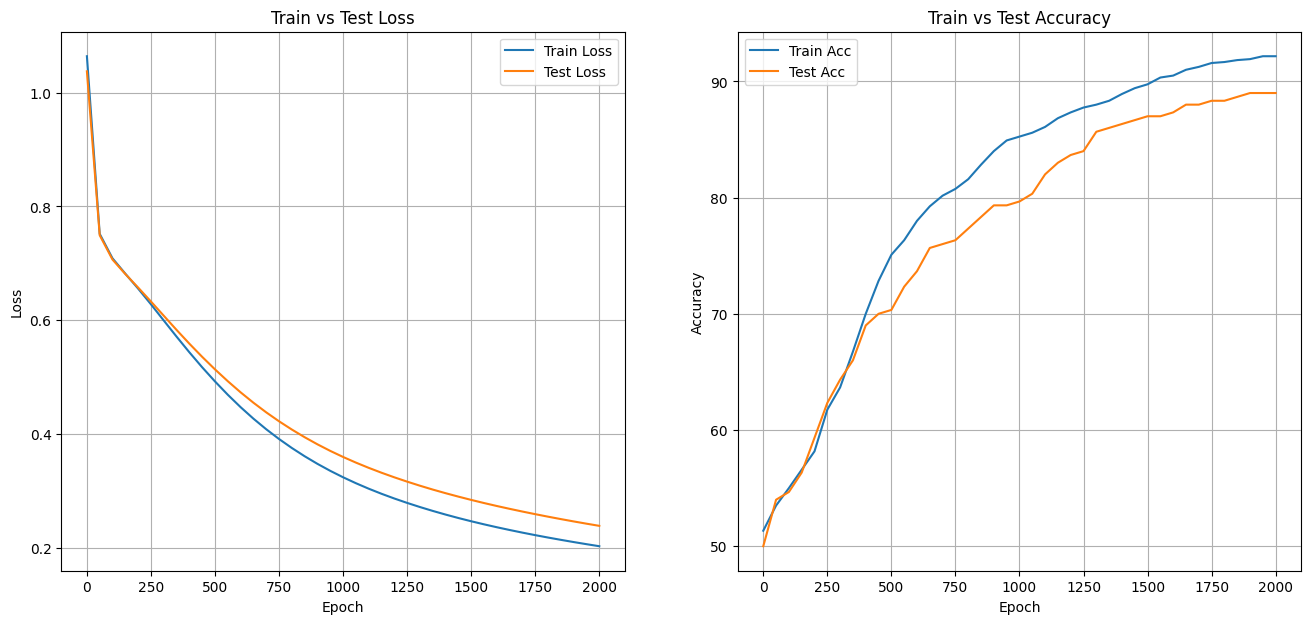

In [18]:
model_1_graphs = plot_graphs(epochs_count_1, loss_values_1, test_loss_values_1, acc_values_1, test_acc_values_1)

In [19]:
def plot_results(model, X_train, X_test, y_train, y_test):
    fig = plt.figure(figsize=(16, 7))
    plt.subplot(1, 2, 1)
    plt.title("Train Result")
    plot_decision_boundary(model, X_train, y_train)
    plt.subplot(1, 2, 2)
    plt.title("Test Result")
    plot_decision_boundary(model, X_test, y_test)
    return fig

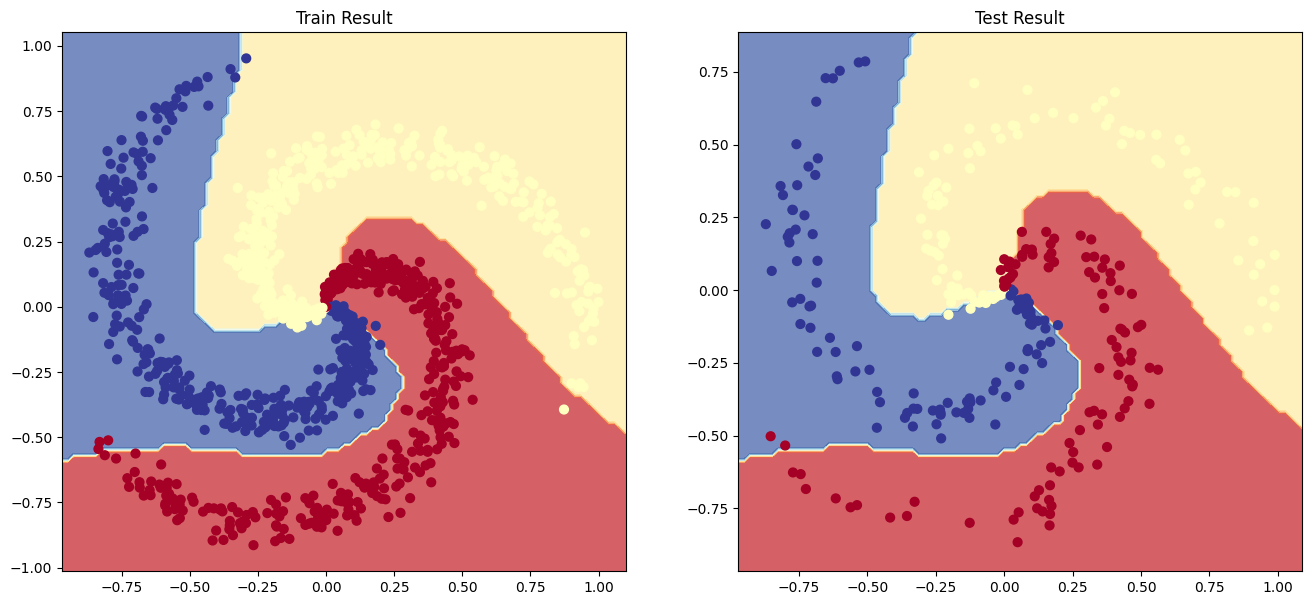

In [20]:
model_1_results = plot_results(model_1, X_spiral_train, X_spiral_test, y_spiral_train, y_spiral_test)

## splitting data three ways into train, validation and test

In [21]:
print("Applying the train-test-split once for splitting off the 20% Test Data Part, holding 80% for second split")
print("Applying the train-test-split twice for splitting the the remaining 80% into Training and Validation")

Applying the train-test-split once for splitting off the 20% Test Data Part, holding 80% for second split
Applying the train-test-split twice for splitting the the remaining 80% into Training and Validation


In [22]:
X_hold, X_test, y_hold, y_test = train_test_split(X_spiral, y_spiral,
                                                  test_size=0.2,
                                                  random_state=50,
                                                  stratify=y_spiral)

X_train, X_val, y_train, y_val = train_test_split(X_hold, y_hold,
                                                  test_size=0.25, random_state=50,
                                                  stratify=y_hold)

In [23]:
print(f"Complete Data Shape: {X_spiral.shape}, {y_spiral.shape}")
print(f"Train Data Shape: {X_train.shape}, {y_train.shape}")
print(f"Validation Data Shape: {X_val.shape}, {y_val.shape}")
print(f"Test Data Shape: {X_test.shape}, {y_test.shape}")


Complete Data Shape: torch.Size([1500, 2]), torch.Size([1500])
Train Data Shape: torch.Size([900, 2]), torch.Size([900])
Validation Data Shape: torch.Size([300, 2]), torch.Size([300])
Test Data Shape: torch.Size([300, 2]), torch.Size([300])


In [24]:
print(f"Train Data: {type(X_train)}, {type(y_train)}, {X_train.dtype}, {y_train.dtype}")
print(f"Validation Data: {type(X_val)}, {type(y_val)}, {X_val.dtype}, {y_val.dtype}")
print(f"Test Data: {type(X_test)}, {type(y_test)}, {X_test.dtype}, {y_val.dtype}")

Train Data: <class 'torch.Tensor'>, <class 'torch.Tensor'>, torch.float32, torch.int64
Validation Data: <class 'torch.Tensor'>, <class 'torch.Tensor'>, torch.float32, torch.int64
Test Data: <class 'torch.Tensor'>, <class 'torch.Tensor'>, torch.float32, torch.int64


In [25]:
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

In [26]:
print("900 Train-Samples split into batches of 64:\n")
for x, y in train_loader:
    print(x.shape, y.shape)

900 Train-Samples split into batches of 64:

torch.Size([64, 2]) torch.Size([64])
torch.Size([64, 2]) torch.Size([64])
torch.Size([64, 2]) torch.Size([64])
torch.Size([64, 2]) torch.Size([64])
torch.Size([64, 2]) torch.Size([64])
torch.Size([64, 2]) torch.Size([64])
torch.Size([64, 2]) torch.Size([64])
torch.Size([64, 2]) torch.Size([64])
torch.Size([64, 2]) torch.Size([64])
torch.Size([64, 2]) torch.Size([64])
torch.Size([64, 2]) torch.Size([64])
torch.Size([64, 2]) torch.Size([64])
torch.Size([64, 2]) torch.Size([64])
torch.Size([64, 2]) torch.Size([64])
torch.Size([4, 2]) torch.Size([4])


In [27]:
print("300 Validation-Samples split into batches of 64:\n")
for x, y in val_loader:
    print(x.shape, y.shape)

300 Validation-Samples split into batches of 64:

torch.Size([64, 2]) torch.Size([64])
torch.Size([64, 2]) torch.Size([64])
torch.Size([64, 2]) torch.Size([64])
torch.Size([64, 2]) torch.Size([64])
torch.Size([44, 2]) torch.Size([44])


In [28]:
print("300 Test-Samples split into batches of 64:\n")
for x, y in test_loader:
    print(x.shape, y.shape)

300 Test-Samples split into batches of 64:

torch.Size([64, 2]) torch.Size([64])
torch.Size([64, 2]) torch.Size([64])
torch.Size([64, 2]) torch.Size([64])
torch.Size([64, 2]) torch.Size([64])
torch.Size([44, 2]) torch.Size([44])


In [29]:
def train_step(model, loss_fn, accuracy_fn, optimizer, dataloader):
    model.train()
    total_loss = 0.0
    total_acc = 0.0
    num_batches = 0

    for X_train_batch, y_train_batch in dataloader:
        y_logits = model(X_train_batch)

        y_pred = torch.softmax(y_logits, dim=1)
        y_pred = torch.argmax(y_pred, dim=1)

        loss = loss_fn(y_logits, y_train_batch)
        acc = accuracy_fn(y_train_batch, y_pred)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_acc += acc
        num_batches += 1
        
    return total_loss / num_batches, total_acc / num_batches

In [30]:
def val_step(model, loss_fn, accuracy_fn, dataloader):
    model.eval()
    total_val_loss = 0.0
    total_val_acc = 0.0
    num_batches = 0

    with torch.inference_mode():
        for X_batch, y_batch in dataloader:
            val_logits = model(X_batch)

            val_pred = torch.softmax(val_logits, dim=1)
            val_pred = torch.argmax(val_pred, dim=1)

            val_loss = loss_fn(val_logits, y_batch)
            val_acc = accuracy_fn(y_batch, val_pred)
        
            total_val_loss += val_loss.item()
            total_val_acc += val_acc
            num_batches += 1
        
        return total_val_loss / num_batches, total_val_acc / num_batches

In [31]:

def train_loop_3_way_split(model, loss_fn, accuracy_fn, optimizer, 
                           dataloader_train, dataloader_val, dataloader_test,
                           num_epochs=2050, print_freq=50, device="cpu"):

    epochs_count_3w_1 = []
    loss_values_3w_1 = []
    val_loss_values_3w_1 = []
    test_loss_values_3w = []
    acc_values_3w_1 = []
    val_acc_values_3w_1 = []
    test_acc_values_3w = []

    for epoch in range(num_epochs):
        train_loss, train_acc = train_step(model, loss_fn, accuracy_fn, optimizer, dataloader_train)
        val_loss, val_acc = val_step(model, loss_fn, accuracy_fn, dataloader_val)
        test_loss, test_acc = val_step(model, loss_fn, accuracy_fn, dataloader_test)

        if epoch % print_freq == 0:
            epochs_count_3w_1.append(epoch)
            loss_values_3w_1.append(train_loss)
            val_loss_values_3w_1.append(val_loss)
            test_loss_values_3w.append(test_loss)
            acc_values_3w_1.append(train_acc)
            val_acc_values_3w_1.append(val_acc)
            test_acc_values_3w.append(test_acc)
            print(f"Epoch: {epoch} | Loss: {train_loss:.3f} | Acc: {train_acc:.3f} | Val Loss: {val_loss:.3f} | Val Acc: {val_acc:.3f} | Test Loss: {test_loss:.3f} | Test Acc: {test_acc:.3f}")
    


    return epochs_count_3w_1, loss_values_3w_1, val_loss_values_3w_1, test_loss_values_3w, acc_values_3w_1, val_acc_values_3w_1, test_acc_values_3w

In [32]:
epochs_3w_1, loss_3w_1, val_loss_3w_1, test_loss_3w, acc_3w_1, val_acc_3w_1, test_acc_3w = train_loop_3_way_split(model_1, loss_fn_1, accuracy_fn, optimizer_1, train_loader, val_loader, test_loader)

Epoch: 0 | Loss: 0.215 | Acc: 90.625 | Val Loss: 0.197 | Val Acc: 94.119 | Test Loss: 0.176 | Test Acc: 95.199
Epoch: 50 | Loss: 0.168 | Acc: 93.229 | Val Loss: 0.164 | Val Acc: 94.574 | Test Loss: 0.136 | Test Acc: 95.994
Epoch: 100 | Loss: 0.138 | Acc: 95.833 | Val Loss: 0.142 | Val Acc: 95.824 | Test Loss: 0.115 | Test Acc: 96.619
Epoch: 150 | Loss: 0.122 | Acc: 96.667 | Val Loss: 0.118 | Val Acc: 96.591 | Test Loss: 0.093 | Test Acc: 98.778
Epoch: 200 | Loss: 0.117 | Acc: 96.875 | Val Loss: 0.123 | Val Acc: 94.886 | Test Loss: 0.093 | Test Acc: 95.994
Epoch: 250 | Loss: 0.092 | Acc: 98.333 | Val Loss: 0.095 | Val Acc: 96.733 | Test Loss: 0.070 | Test Acc: 97.386
Epoch: 300 | Loss: 0.078 | Acc: 98.854 | Val Loss: 0.085 | Val Acc: 97.670 | Test Loss: 0.062 | Test Acc: 98.778
Epoch: 350 | Loss: 0.074 | Acc: 98.854 | Val Loss: 0.076 | Val Acc: 98.295 | Test Loss: 0.055 | Test Acc: 99.233
Epoch: 400 | Loss: 0.065 | Acc: 99.167 | Val Loss: 0.072 | Val Acc: 98.295 | Test Loss: 0.052 | Tes

In [33]:
def plot_graphs_3w(epochs__count, loss__values, val__loss_values, test__loss_values, acc__values, val__acc_values, test__acc_values):
    fig = plt.figure(figsize=(16, 7))
    plt.subplot(1, 2, 1)
    plt.grid(True)
    plt.title("Train vs Validation vs Test Loss")
    plt.plot(epochs__count, np.array(torch.tensor(loss__values).numpy()), label="Train Loss")
    plt.plot(epochs__count, np.array(torch.tensor(val__loss_values).numpy()), label="Validation Loss")
    plt.plot(epochs__count, np.array(torch.tensor(test__loss_values).numpy()), label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend();
    plt.subplot(1, 2, 2)
    plt.grid(True)
    plt.title("Train vs Validation vs Test Accuracy")
    plt.plot(epochs__count, np.array(torch.tensor(acc__values).numpy()), label="Train Acc")
    plt.plot(epochs__count, np.array(torch.tensor(val__acc_values).numpy()), label="Validation Acc")
    plt.plot(epochs__count, np.array(torch.tensor(test__acc_values).numpy()), label="Test Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend();
    return fig

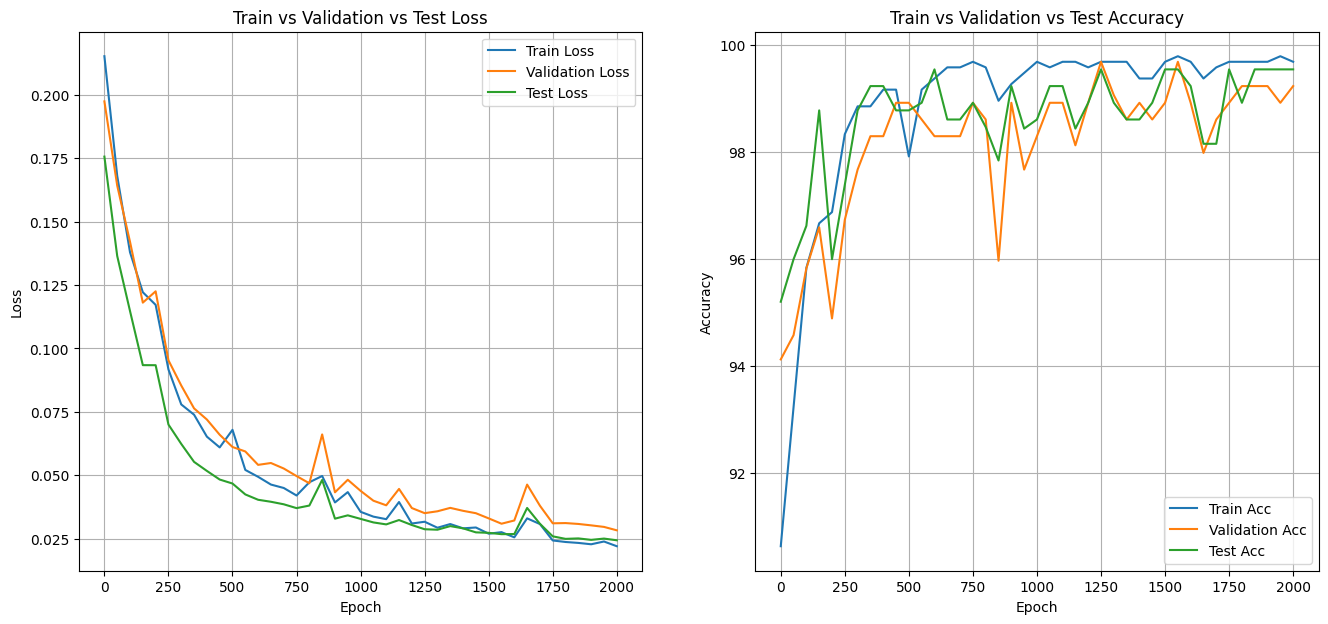

In [34]:
model_1_3w_opt1_graphs = plot_graphs_3w(epochs_3w_1, loss_3w_1, val_loss_3w_1, test_loss_3w, acc_3w_1, val_acc_3w_1, test_acc_3w)

In [35]:
def extract_data_from_loader(dataloader):
    X_list = [] 
    y_list = []
    for X_batch, y_batch in dataloader:
        X_list.append(X_batch)
        y_list.append(y_batch)
    
    X_full = torch.cat(X_list, dim=0)
    y_full = torch.cat(y_list, dim=0)
    return X_full, y_full

In [36]:
from three_way_plotter import plot_decision_boundary_3w

def plot_result_3w(model, train__loader, val__loader, test__loader):
    X__train_3w, y__train_3w = extract_data_from_loader(train__loader)
    X__val_3w, y__val_3w = extract_data_from_loader(val__loader)
    X__test_3w, y__test_3w = extract_data_from_loader(test__loader)

    fig = plt.figure(figsize=(15, 6))
    plt.subplot(1, 3, 1)
    plt.title("Train Set")
    plot_decision_boundary_3w(model_1, X__train_3w, y__train_3w)
    plt.subplot(1, 3, 2)
    plt.title("Validation Set")
    plot_decision_boundary_3w(model_1, X__val_3w, y__val_3w)
    plt.subplot(1, 3, 3)
    plt.title("Test Set")
    plot_decision_boundary_3w(model, X__test_3w, y__test_3w)


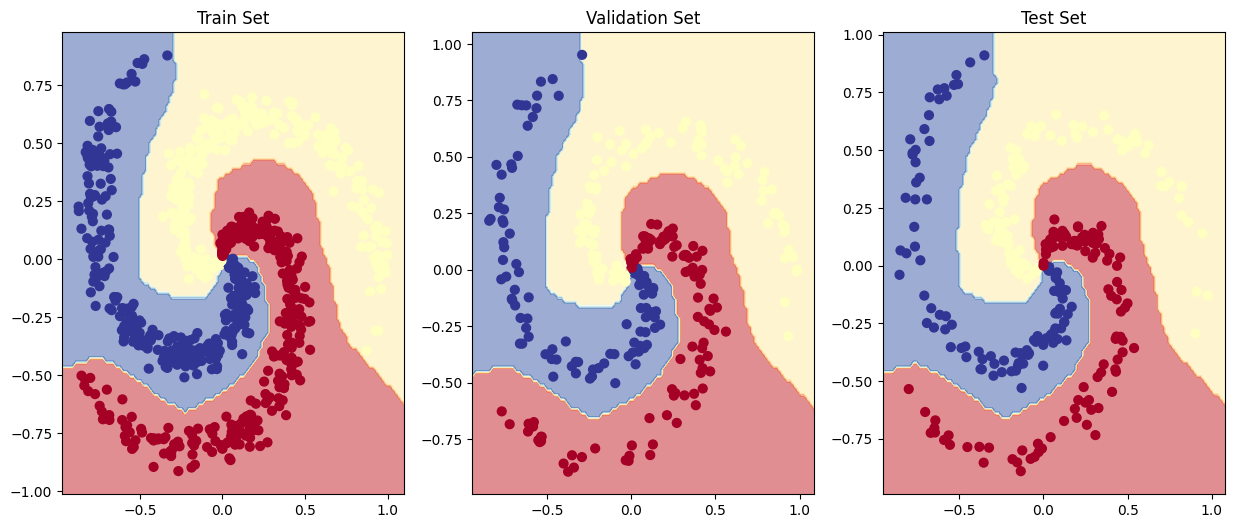

In [37]:
model_1_3w_opt1_results = plot_result_3w(model_1, train_loader, val_loader, test_loader)

In [38]:
epochs_3w_12, loss_3w_12, val_loss_3w_12, test_loss_3w_12, acc_3w_12, val_acc_3w_12, test_acc_3w_12 = train_loop_3_way_split(model_1, loss_fn_1, accuracy_fn, adam001_1, train_loader, val_loader, test_loader)

Epoch: 0 | Loss: 0.032 | Acc: 98.750 | Val Loss: 0.043 | Val Acc: 98.920 | Test Loss: 0.029 | Test Acc: 99.233
Epoch: 50 | Loss: 0.011 | Acc: 99.896 | Val Loss: 0.016 | Val Acc: 100.000 | Test Loss: 0.018 | Test Acc: 99.545
Epoch: 100 | Loss: 0.008 | Acc: 99.688 | Val Loss: 0.011 | Val Acc: 99.688 | Test Loss: 0.016 | Test Acc: 99.545
Epoch: 150 | Loss: 0.007 | Acc: 99.792 | Val Loss: 0.010 | Val Acc: 99.688 | Test Loss: 0.013 | Test Acc: 99.545
Epoch: 200 | Loss: 0.007 | Acc: 99.896 | Val Loss: 0.009 | Val Acc: 99.688 | Test Loss: 0.013 | Test Acc: 99.545
Epoch: 250 | Loss: 0.006 | Acc: 99.792 | Val Loss: 0.008 | Val Acc: 99.688 | Test Loss: 0.013 | Test Acc: 99.545
Epoch: 300 | Loss: 0.005 | Acc: 99.896 | Val Loss: 0.010 | Val Acc: 99.375 | Test Loss: 0.011 | Test Acc: 99.688
Epoch: 350 | Loss: 0.005 | Acc: 99.896 | Val Loss: 0.009 | Val Acc: 99.375 | Test Loss: 0.011 | Test Acc: 100.000
Epoch: 400 | Loss: 0.004 | Acc: 99.896 | Val Loss: 0.007 | Val Acc: 99.688 | Test Loss: 0.010 | T

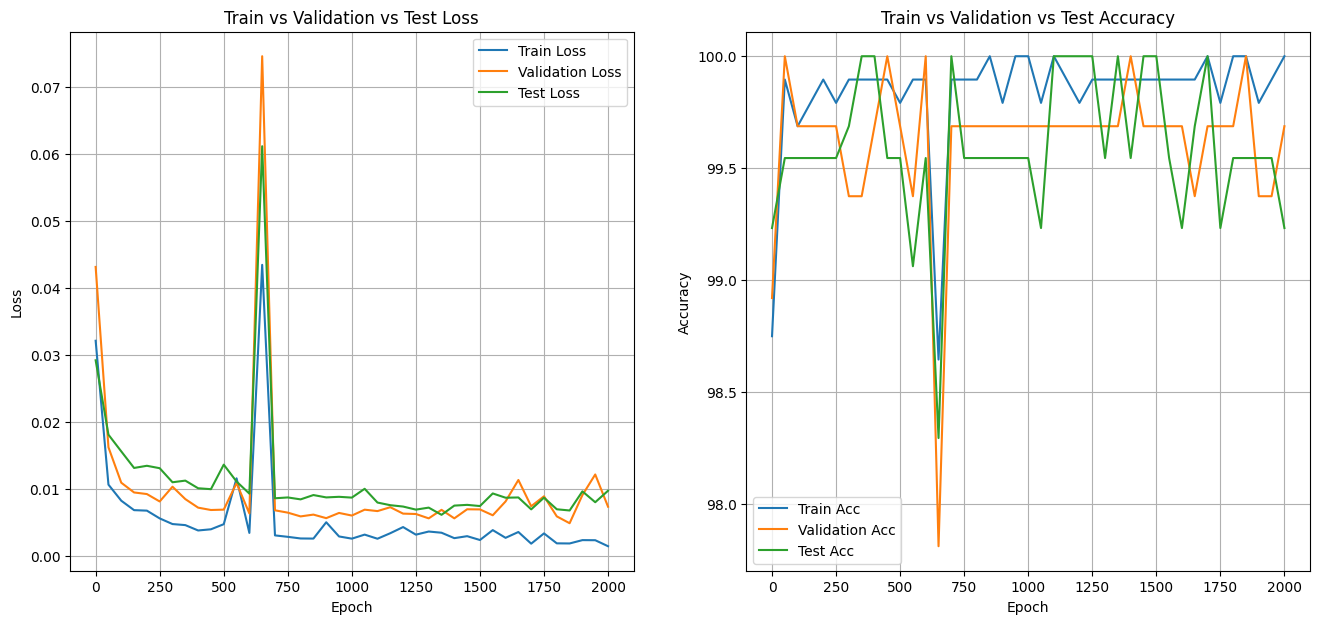

In [39]:
model_1_3w_opt2_graphs = plot_graphs_3w(epochs_3w_12, loss_3w_12, val_loss_3w_12, test_loss_3w_12, acc_3w_12, val_acc_3w_12, test_acc_3w_12)

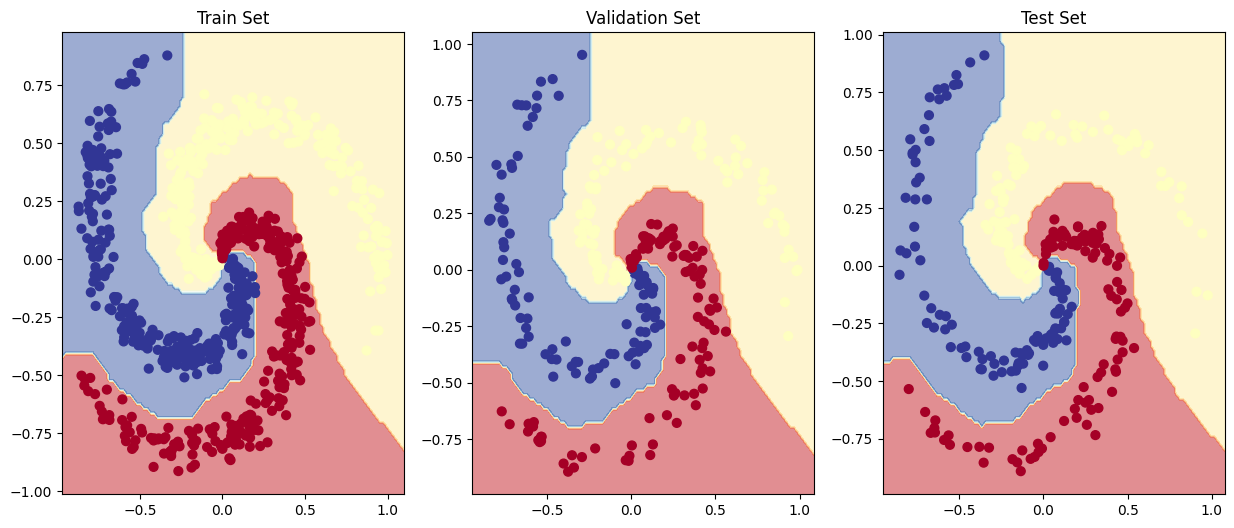

In [40]:
model_1_3w_opt2_results = plot_result_3w(model_1, train_loader, val_loader, test_loader)